# Reading the dataset

In [1]:
# importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading the dataset

data = pd.read_csv('predictive_maintenance.csv')
data.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


Features of the dataset:

1.UID: unique identifier ranging from 1 to 10000
    
2.productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product 
quality variants and a variant-specific serial number

3.air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
    
4.process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, 
added to the air temperature plus 10 K.

5.rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
    
6.torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
    
7.tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the 
following failure modes are true.

The targets are:
    
Target: failure or no failure (to perform binary classification).

Failure Type: type of failure (to perform multiclass classification).

# Exploratory Data Analysis

In [3]:
data.shape

(10000, 10)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
data.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [6]:
data.describe(exclude = np.number)

,Product ID,Type,Failure Type
count,10000,10000,10000
unique,10000,3,6
top,M14860,L,No Failure
freq,1,6000,9652


In [7]:
data.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

The columns UDI and Product ID are not important in building the model so we are removing that.

In [8]:
data.drop(['UDI','Product ID'], axis = 1, inplace = True)

In [9]:
#changing the name of the columns

data = data.rename({'Air temperature [K]': 'Air temperature',
                       'Process temperature [K]': 'Process temperature',
                       'Rotational speed [rpm]': 'Rotational speed',
                       'Torque [Nm]': 'Torque', 
                       'Tool wear [min]': 'Tool wear'}, axis=1)

In [10]:
data['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

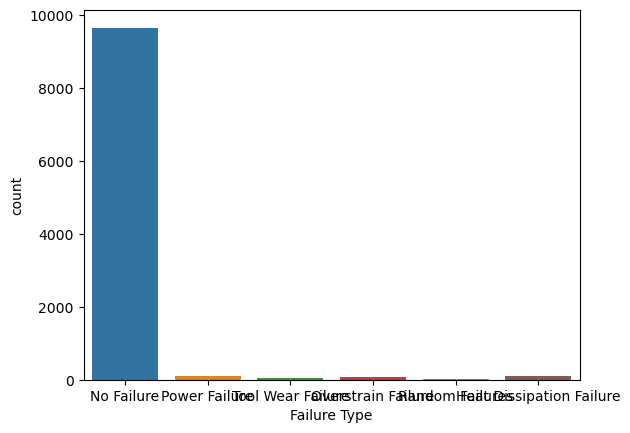

In [11]:
sns.countplot(data['Failure Type'])
plt.show()

In [12]:
data['Target'].value_counts()

0    9661
1     339
Name: Target, dtype: int64

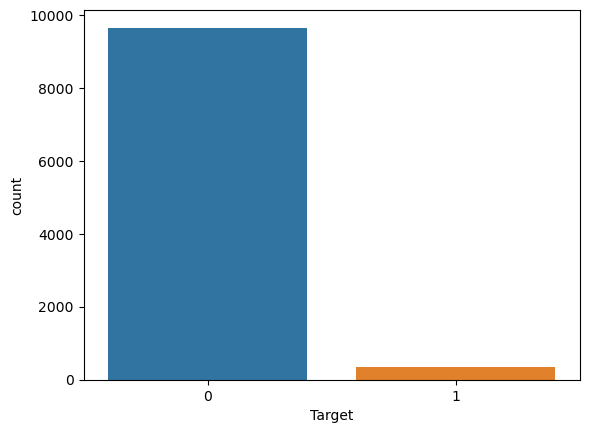

In [13]:
sns.countplot(data['Target'])
plt.show()

We can see that our dataset is highly imbalanced from the above.

In [14]:
data['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

This has to be encoded.

In [15]:
#checking the inconsistencies between 'Target' and 'Failure Type'

data_failure = data[data['Target'] == 1]
data_failure['Failure Type'].value_counts()

Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: Failure Type, dtype: int64

We can see that the target is 1 which implies its failure and also 'failure type' is mentioned as no failure in 9 entries.

In [16]:
data_failure[data_failure['Failure Type'] == 'No Failure']

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
1437,H,298.8,309.9,1439,45.2,40,1,No Failure
2749,M,299.7,309.2,1685,28.9,179,1,No Failure
4044,M,301.9,310.9,1419,47.7,20,1,No Failure
4684,M,303.6,311.8,1421,44.8,101,1,No Failure
5536,M,302.3,311.8,1363,54.0,119,1,No Failure
5941,L,300.6,310.7,1438,48.5,78,1,No Failure
6478,L,300.5,309.8,1663,29.1,145,1,No Failure
8506,L,298.4,309.6,1710,27.3,163,1,No Failure
9015,L,297.2,308.1,1431,49.7,210,1,No Failure


In [17]:
#Dropping those irrelevent rows

index_possible_failure = data_failure[data_failure['Failure Type'] == 'No Failure'].index

data.drop(index_possible_failure, axis=0, inplace=True)

In [18]:
data2_failure = data[data['Target'] == 0]
data2_failure['Failure Type'].value_counts()

No Failure         9643
Random Failures      18
Name: Failure Type, dtype: int64

similarly,We can see that the target is 0 which implies its as no failure and 
also 'failure type' is mentioned as 'random failure' in 18 entries.

In [19]:
data2_failure[data2_failure['Failure Type'] == 'Random Failures']

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
1221,M,297.0,308.3,1399,46.4,132,0,Random Failures
1302,L,298.6,309.8,1505,45.7,144,0,Random Failures
1748,H,298.4,307.7,1626,31.1,166,0,Random Failures
2072,L,299.6,309.5,1570,35.5,189,0,Random Failures
2559,L,299.3,309.0,1447,50.4,140,0,Random Failures
3065,M,300.1,309.2,1687,27.7,95,0,Random Failures
3452,H,301.6,310.5,1602,32.3,2,0,Random Failures
5471,L,302.7,312.3,1346,61.2,170,0,Random Failures
5489,L,302.6,312.1,1499,35.0,215,0,Random Failures
5495,H,302.9,312.5,1357,55.0,12,0,Random Failures


In [20]:
#Dropping those irrelevent rows

index_possible_failure2 = data2_failure[data2_failure['Failure Type'] == 'Random Failures'].index

data.drop(index_possible_failure2, axis=0, inplace=True)

In [21]:
data.shape

(9973, 8)

In [22]:
#reseting the index numbers

data.reset_index(inplace=True, drop=True)

# Visualization

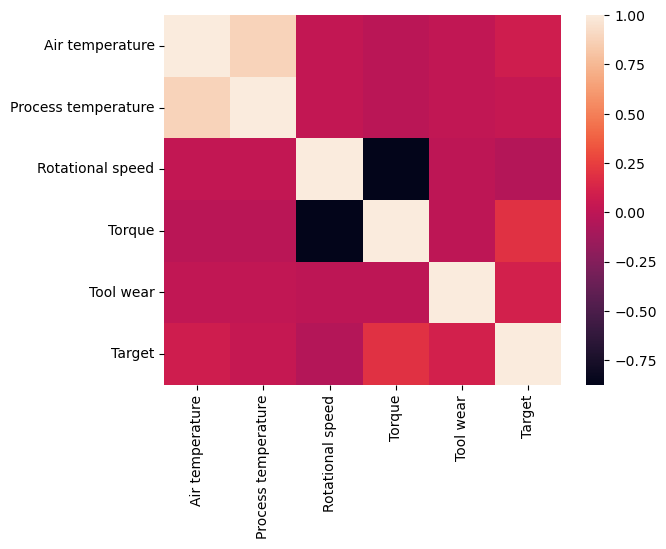

In [23]:
sns.heatmap(data.corr(), cbar = True)
plt.show()

1. Torque and rotational speed are highly negatively correlated
2. Air temperature and Process temperature are also highly correlated but positively 

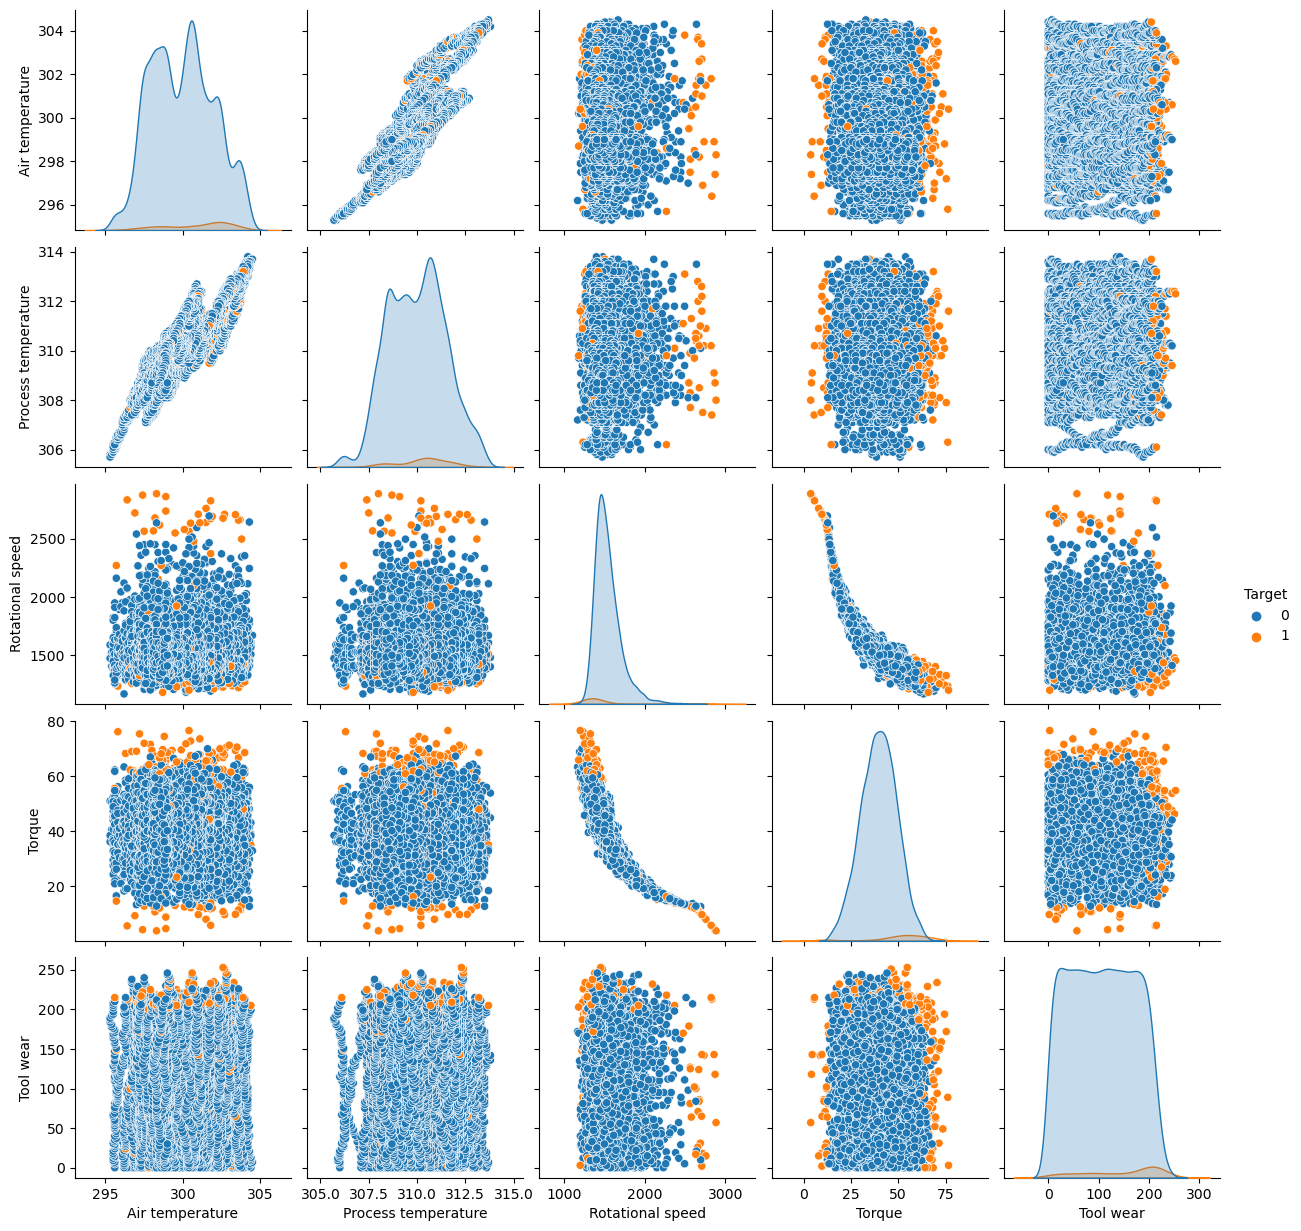

In [24]:
sns.pairplot(data, hue='Target')
plt.show()

We can see that failures occur for extreme values of some features, the machinery fails either for the lowest or largest
values of 'torque' and 'rotational speed'. This is easily spotted in the graph since the orange dots are far apart for those 
features. So, there is a range for normal conditions in which the machines operate, 
and above or under this range, they tend to fail.

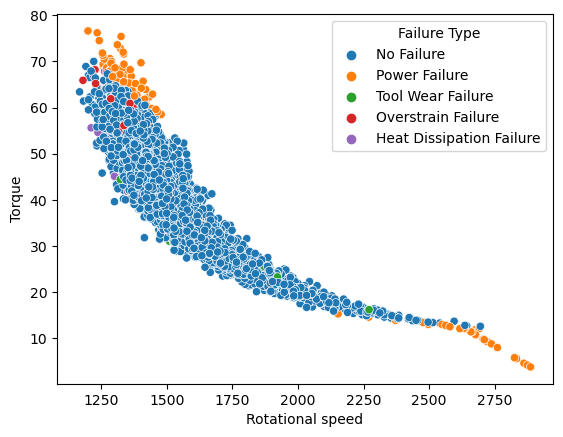

In [25]:
sns.scatterplot(data=data, x='Rotational speed', y='Torque', hue='Failure Type')
plt.show()

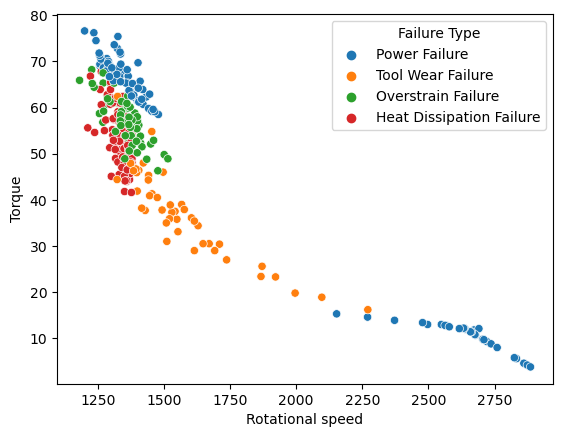

In [26]:
sns.scatterplot(data=data[data['Target'] == 1], x='Rotational speed', y='Torque', hue='Failure Type')
plt.show()

1.Power failure happens both for lower and higher rotational speed/torque. It is the type of failure with the highest 
rotational speed (over 2500rpm) and lowest torque (below around 15Nm). In other speed/Torques, above and below these thresholds 
only power failures occur.

2.Between torques 16Nm and 41Nm all failures are tool wear.

3.Overstrain failures take place with torques ranging from around 47 and 68Nm) and rotational speeds from 1200 to 1500rpm 
approximately.

4.For heat dissipation failures, the torque range is smaller and the rotational speed range is bigger compared to overstrain 
failures.

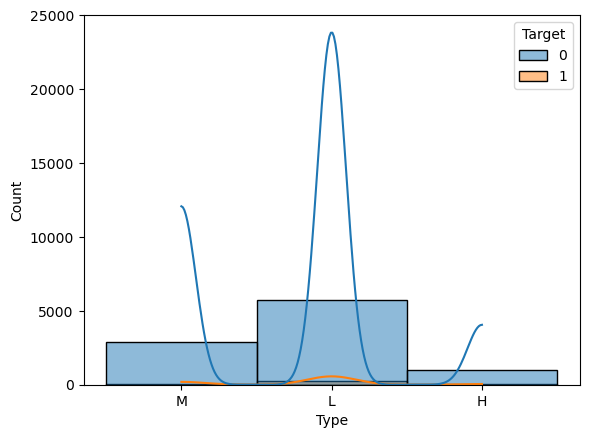

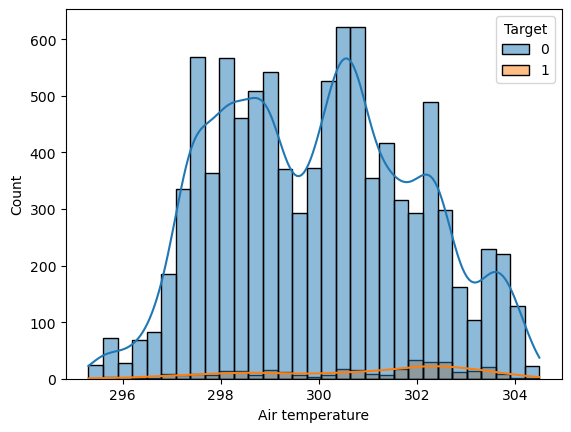

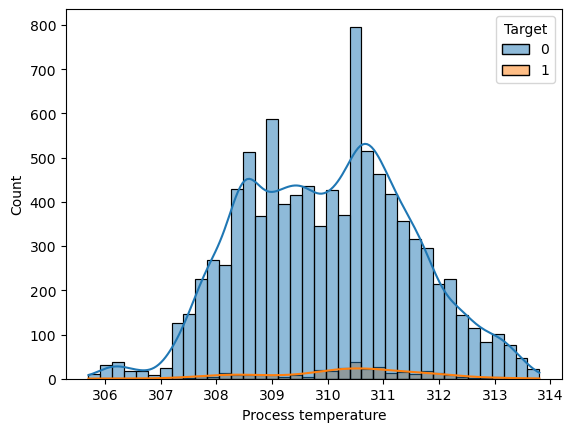

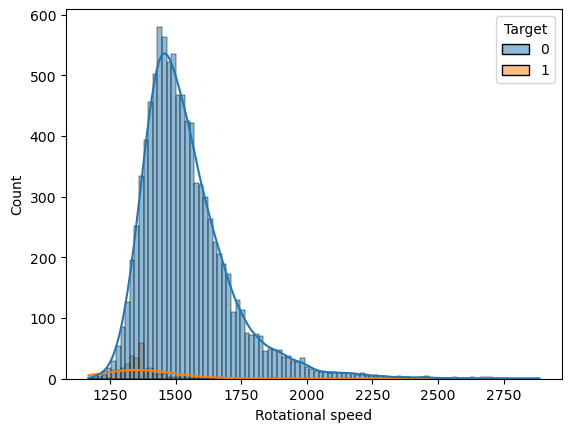

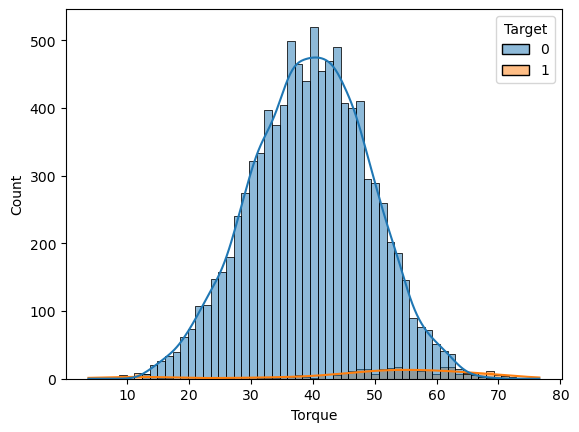

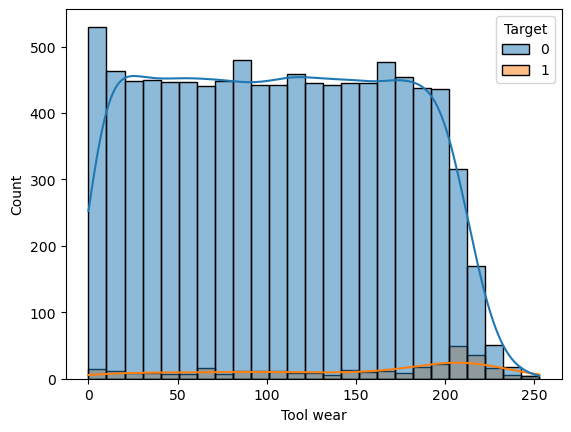

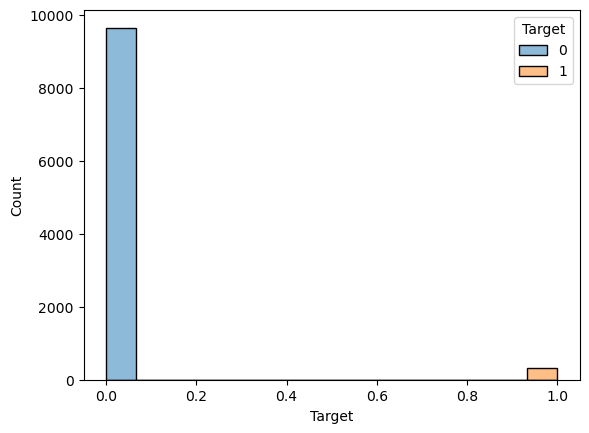

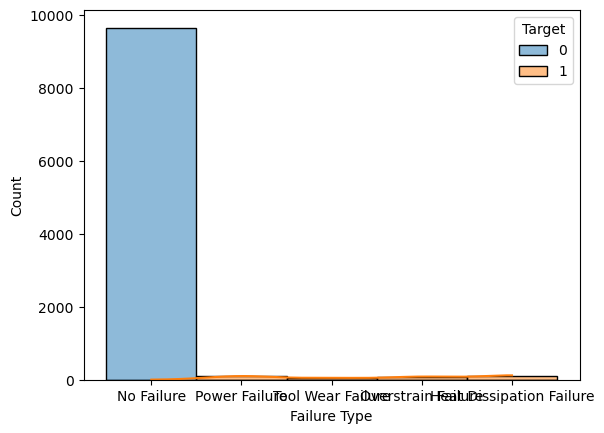

In [27]:
for i in data.columns:
    sns.histplot(data=data, x=i, kde=True, hue='Target')
    plt.show()

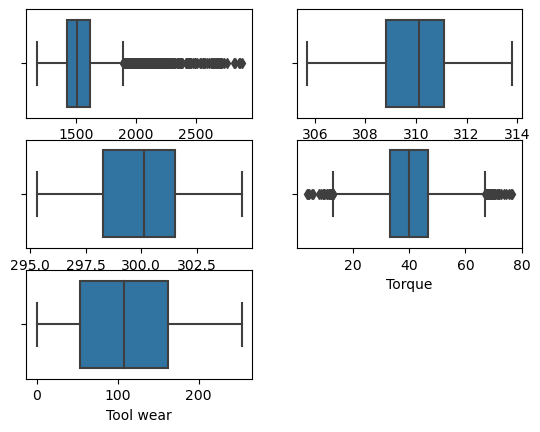

In [28]:
plt.subplot(3,2,1)
sns.boxplot(data = data, x= data['Rotational speed'])
plt.subplot(3,2,2)
sns.boxplot(data = data, x= data['Process temperature'])
plt.subplot(3,2,3)
sns.boxplot(data = data, x= data['Air temperature'])
plt.subplot(3,2,4)
sns.boxplot(data = data, x= data['Torque'])
plt.subplot(3,2,5)
sns.boxplot(data = data, x= data['Tool wear'])
plt.show()

# Removing Outliers

In [29]:
#treating the outliers

Q1 = data['Rotational speed'].quantile(0.25)
Q3 = data['Rotational speed'].quantile(0.75)
IQR= Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['Rotational speed'] > lower_bound) & (data['Rotational speed'] < upper_bound)]

In [30]:
#treating the outliers

Q1 = data['Torque'].quantile(0.25)
Q3 = data['Torque'].quantile(0.75)
IQR= Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['Torque'] > lower_bound) & (data['Torque'] < upper_bound)]

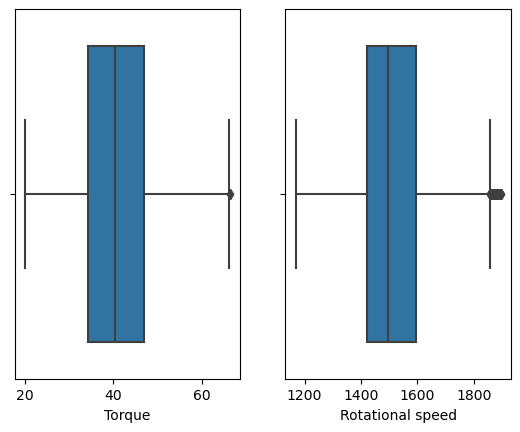

In [31]:
plt.subplot(1,2,1)
sns.boxplot(data = data, x= data['Torque'])
plt.subplot(1,2,2)
sns.boxplot(data = data, x= data['Rotational speed'])
plt.show()

# Feature Engineering

In [32]:
data.head(5)

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


In [33]:
data.isna().sum()

Type                   0
Air temperature        0
Process temperature    0
Rotational speed       0
Torque                 0
Tool wear              0
Target                 0
Failure Type           0
dtype: int64

In [34]:
#Encoding of the 'type' and 'failure type' columns

from sklearn.preprocessing import OrdinalEncoder

columns_failure_type = data['Failure Type'].unique().tolist()

ord_enc = OrdinalEncoder(categories=[['L', 'M', 'H'], columns_failure_type])

new_dat = ord_enc.fit_transform(data[['Type', 'Failure Type']])
new_dat

data.drop(['Type', 'Failure Type'], axis=1, inplace=True)

new_df = pd.DataFrame(new_dat, 
                      index=data.index, 
                      columns=['Type', 'Failure Type'])

df = pd.concat([data, new_df], axis=1)

In [35]:
df.isna().sum()

Air temperature        0
Process temperature    0
Rotational speed       0
Torque                 0
Tool wear              0
Target                 0
Type                   0
Failure Type           0
dtype: int64

In [36]:
df.head()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Type,Failure Type
0,298.1,308.6,1551,42.8,0,0,1.0,0.0
1,298.2,308.7,1408,46.3,3,0,0.0,0.0
2,298.1,308.5,1498,49.4,5,0,0.0,0.0
3,298.2,308.6,1433,39.5,7,0,0.0,0.0
4,298.2,308.7,1408,40.0,9,0,0.0,0.0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9972
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Air temperature      9508 non-null   float64
 1   Process temperature  9508 non-null   float64
 2   Rotational speed     9508 non-null   int64  
 3   Torque               9508 non-null   float64
 4   Tool wear            9508 non-null   int64  
 5   Target               9508 non-null   int64  
 6   Type                 9508 non-null   float64
 7   Failure Type         9508 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 668.5 KB


In [38]:
#scaling of the dataset

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

columns = ['Air temperature','Process temperature','Rotational speed','Torque','Tool wear']

df[columns] = sc.fit_transform(df[columns])
#features_scaled = pd.DataFrame(features_scaled, columns=columns)

In [39]:
df.head(5)

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Type,Failure Type
0,-0.947852,-0.944392,0.274307,0.229262,-1.698656,0,1.0,0.0
1,-0.897746,-0.876873,-0.827457,0.622756,-1.651465,0,0.0,0.0
2,-0.947852,-1.011910,-0.134039,0.971279,-1.620005,0,0.0,0.0
3,-0.897746,-0.944392,-0.634840,-0.141747,-1.588545,0,0.0,0.0
4,-0.897746,-0.876873,-0.827457,-0.085533,-1.557085,0,0.0,0.0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9972
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Air temperature      9508 non-null   float64
 1   Process temperature  9508 non-null   float64
 2   Rotational speed     9508 non-null   float64
 3   Torque               9508 non-null   float64
 4   Tool wear            9508 non-null   float64
 5   Target               9508 non-null   int64  
 6   Type                 9508 non-null   float64
 7   Failure Type         9508 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 668.5 KB


In [41]:
df['Type'] = df['Type'].astype('int')
df['Failure Type'] = df['Failure Type'].astype('int')
df['Target'] = df['Target'].astype('int')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9972
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Air temperature      9508 non-null   float64
 1   Process temperature  9508 non-null   float64
 2   Rotational speed     9508 non-null   float64
 3   Torque               9508 non-null   float64
 4   Tool wear            9508 non-null   float64
 5   Target               9508 non-null   int32  
 6   Type                 9508 non-null   int32  
 7   Failure Type         9508 non-null   int32  
dtypes: float64(5), int32(3)
memory usage: 557.1 KB


# Modeling with 'Target' variable

In [43]:
#train/test split using Stratified shuffled split -- since the dataset is highly imbalanced

x = df.drop(['Target', 'Failure Type'], axis=1)
y = df['Target']

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(x, y):
    
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1851
           1       0.80      0.24      0.36        51

    accuracy                           0.98      1902
   macro avg       0.89      0.62      0.68      1902
weighted avg       0.97      0.98      0.97      1902



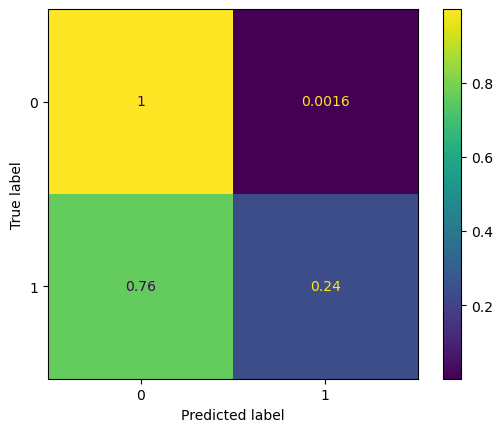

In [44]:
#logistic Regression

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lrmodel = lr.fit(xtrain,ytrain)
lrpred  = lr.predict(xtest)

print(classification_report(ytest, lrpred))

print(plot_confusion_matrix(lr, xtest, ytest, normalize='true'))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1851
           1       0.69      0.73      0.70        51

    accuracy                           0.98      1902
   macro avg       0.84      0.86      0.85      1902
weighted avg       0.98      0.98      0.98      1902



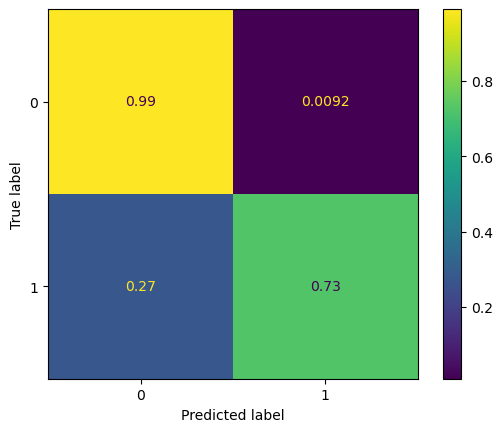

In [45]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier

dr = DecisionTreeClassifier()

drmodel = dr.fit(xtrain,ytrain)
drpred  = dr.predict(xtest)

print(classification_report(ytest, drpred))

print(plot_confusion_matrix(dr, xtest, ytest, normalize='true'))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1851
           1       0.97      0.61      0.75        51

    accuracy                           0.99      1902
   macro avg       0.98      0.80      0.87      1902
weighted avg       0.99      0.99      0.99      1902



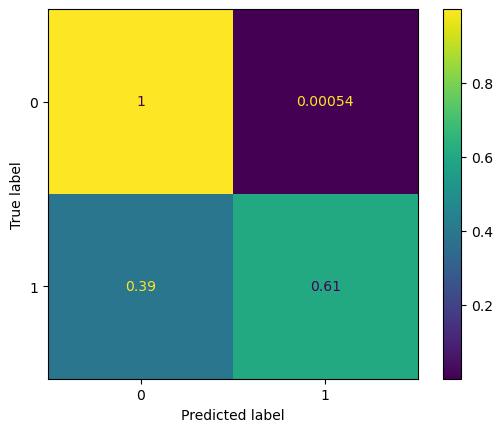

In [46]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rfmodel = rf.fit(xtrain,ytrain)
rfpred  = rf.predict(xtest)

print(classification_report(ytest, rfpred))

print(plot_confusion_matrix(rf, xtest, ytest, normalize='true'))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1851
           1       0.89      0.65      0.75        51

    accuracy                           0.99      1902
   macro avg       0.94      0.82      0.87      1902
weighted avg       0.99      0.99      0.99      1902



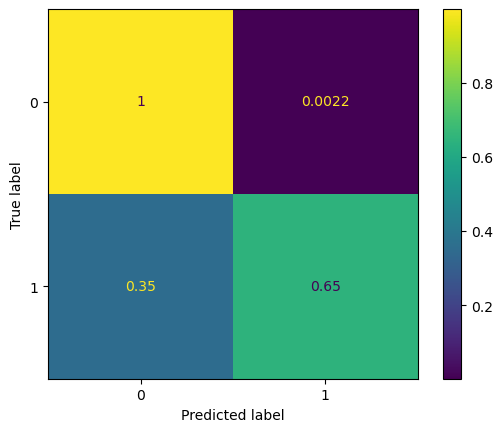

In [47]:
#XGBoost 

from xgboost import XGBClassifier

xg = XGBClassifier()

xgmodel = xg.fit(xtrain,ytrain)
xgpred  = xg.predict(xtest)

print(classification_report(ytest, xgpred))

print(plot_confusion_matrix(xg, xtest, ytest, normalize='true'))

In [48]:
#XGBoost - Grid Search CV

from sklearn.model_selection import GridSearchCV

Params = {'max_depth' : [3,5,7], 'n_estimators': [100,150,200,175], 'learning_rate' : [0.1,0.2,0.01,0.02,0.5]}

xgb = XGBClassifier()

grid = GridSearchCV(estimator=xgb,param_grid = Params, cv= 5, n_jobs= 5)
grid.fit(xtrain,ytrain)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=Non

In [49]:
grid.best_params_

{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1851
           1       0.82      0.63      0.71        51

    accuracy                           0.99      1902
   macro avg       0.91      0.81      0.85      1902
weighted avg       0.99      0.99      0.99      1902



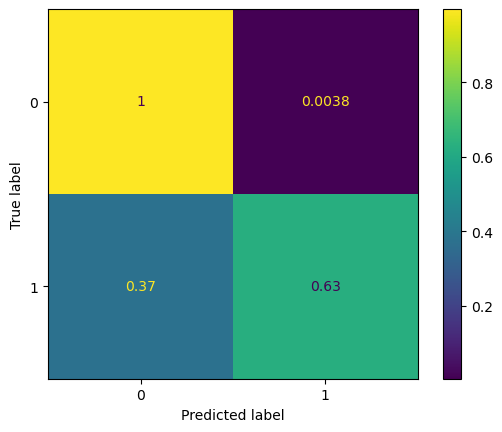

In [50]:
#XGBoost 

from xgboost import XGBClassifier

xg = XGBClassifier(n_estimators = 100, learning_rate = 0.5, max_depth = 3)

xgmodel = xg.fit(xtrain,ytrain)
xgpred  = xg.predict(xtest)

print(classification_report(ytest, xgpred))

print(plot_confusion_matrix(xg, xtest, ytest, normalize='true'))

# Modeling with 'Failure Type' target

In [51]:
x = df.drop(['Target', 'Failure Type'], axis=1)
y = df['Failure Type']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(x, y):
    
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1851
           1       1.00      0.17      0.29         6
           2       0.00      0.00      0.00         8
           3       1.00      0.73      0.85        15
           4       1.00      0.50      0.67        22

    accuracy                           0.99      1902
   macro avg       0.80      0.48      0.56      1902
weighted avg       0.98      0.99      0.98      1902



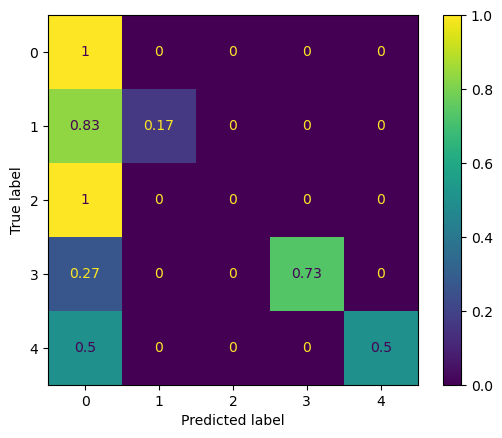

In [52]:
#logistic Regression

lr = LogisticRegression(multi_class= 'multinomial')

lrmodel = lr.fit(x_train,y_train)
lrpred  = lr.predict(x_test)

print(classification_report(y_test, lrpred))

print(plot_confusion_matrix(lr, x_test, y_test, normalize='true'))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1851
           1       0.44      0.67      0.53         6
           2       0.14      0.12      0.13         8
           3       0.56      0.60      0.58        15
           4       1.00      0.91      0.95        22

    accuracy                           0.98      1902
   macro avg       0.63      0.66      0.64      1902
weighted avg       0.98      0.98      0.98      1902



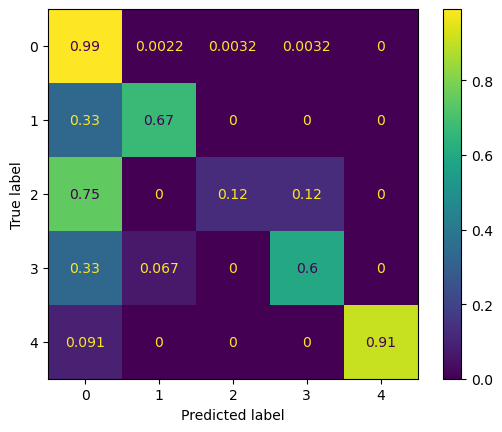

In [53]:
#Decision Tree

dr = DecisionTreeClassifier()

drmodel = dr.fit(x_train,y_train)
drpred  = dr.predict(x_test)

print(classification_report(y_test, drpred))

print(plot_confusion_matrix(dr, x_test, y_test, normalize='true'))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1851
           1       1.00      0.33      0.50         6
           2       0.00      0.00      0.00         8
           3       0.88      0.47      0.61        15
           4       1.00      0.77      0.87        22

    accuracy                           0.99      1902
   macro avg       0.77      0.51      0.59      1902
weighted avg       0.98      0.99      0.98      1902



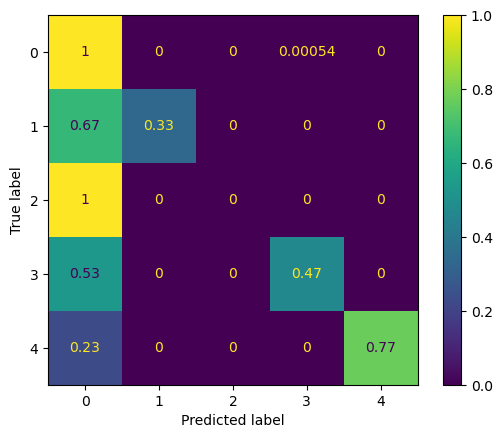

In [54]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rfmodel = rf.fit(x_train,y_train)
rfpred  = rf.predict(x_test)

print(classification_report(y_test, rfpred))

print(plot_confusion_matrix(rf, x_test, y_test, normalize='true'))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1851
           1       0.80      0.67      0.73         6
           2       0.00      0.00      0.00         8
           3       0.87      0.87      0.87        15
           4       1.00      0.91      0.95        22

    accuracy                           0.99      1902
   macro avg       0.73      0.69      0.71      1902
weighted avg       0.99      0.99      0.99      1902



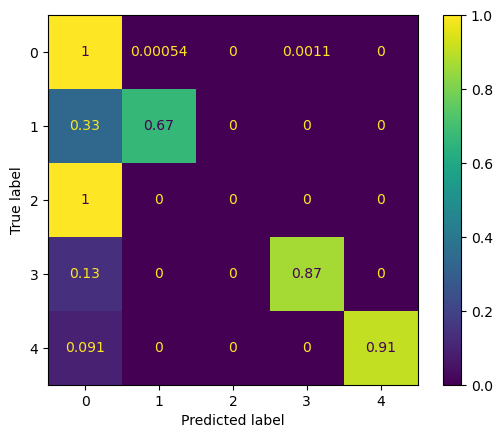

In [55]:
#XGBoost 

from xgboost import XGBClassifier

xg = XGBClassifier()

xgmodel = xg.fit(x_train,y_train)
xgpred  = xg.predict(x_test)

print(classification_report(y_test, xgpred))

print(plot_confusion_matrix(xg, x_test, y_test, normalize='true'))

In [56]:
#XGBoost - Grid Search CV

from sklearn.model_selection import GridSearchCV

Params = {'max_depth' : [3,5,7], 'n_estimators': [100,150,200,175], 'learning_rate' : [0.1,0.2,0.01,0.02,0.5]}

xgb = XGBClassifier()

grid = GridSearchCV(estimator=xgb,param_grid = Params, cv= 5, n_jobs= 5)
grid.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=Non

In [57]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1851
           1       0.67      0.67      0.67         6
           2       0.00      0.00      0.00         8
           3       1.00      0.93      0.97        15
           4       1.00      0.91      0.95        22

    accuracy                           0.99      1902
   macro avg       0.73      0.70      0.72      1902
weighted avg       0.99      0.99      0.99      1902



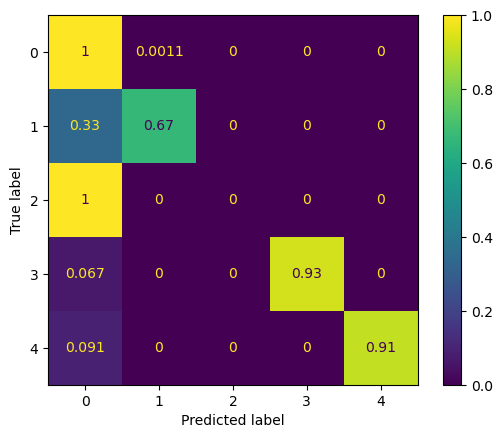

In [58]:
#XGBoost 

from xgboost import XGBClassifier

xg = XGBClassifier(n_estimators = 150, learning_rate = 0.1, max_depth = 3)

xgmodel = xg.fit(x_train,y_train)
xgpred  = xg.predict(x_test)

print(classification_report(y_test, xgpred))

print(plot_confusion_matrix(xg, x_test, y_test, normalize='true'))

In [61]:
import pickle

# open a file, where you ant to store the data
file = open('XGBOOST_model.pkl', 'wb')

# dump information to that file
pickle.dump(grid, file)